In [1]:
# External Lib imports
import re
import os
import html
import pickle
import sklearn
import collections
import pandas as pd
from pathlib import Path
from functools import partial

os.environ['QT_QPA_PLATFORM']='offscreen'

# FastAI Imports
from fastai import text, core, lm_rnn

# Torch imports
import torch.nn as nn
import torch.tensor as T
import torch.nn.functional as F

# Mytorch imports
from mytorch import loops, lriters as mtlr
from mytorch.utils.goodies import *

# Local imports
from options import Phase2 as params

In [2]:
device = torch.device('cuda')
np.random.seed(42)
torch.manual_seed(42)


class CustomEncoder(lm_rnn.RNN_Encoder):

    @property
    def layers(self):
        return torch.nn.ModuleList([torch.nn.ModuleList([self.rnns[0], self.dropouths[0]]),
                                    torch.nn.ModuleList([self.rnns[1], self.dropouths[1]]),
                                    torch.nn.ModuleList([self.rnns[2], self.dropouths[2]])])


class CustomLinear(text.LinearDecoder):

    @property
    def layers(self):
        return torch.nn.ModuleList([self.decoder, self.dropout])


class LanguageModel(nn.Module):

    def __init__(self,
                 _parameter_dict,
                 _device,
                 _wgts_e,
                 _wgts_d,
                 _encargs):
        super(LanguageModel, self).__init__()

        self.parameter_dict = _parameter_dict
        self.device = _device

        self.encoder = CustomEncoder(**_encargs).to(self.device)
        self.encoder.load_state_dict(_wgts_e)
        """
            Explanation:
                400*3 because input is [ h_T, maxpool, meanpool ]
                0.4, 0.1 are drops at various layersLM_PATH
        """
        self.linear = CustomLinear(
            _encargs['ntoken'],
            n_hid=400,
            dropout=0.1 * 0.7,
            tie_encoder=self.encoder.encoder,
            bias=False
        ).to(self.device)
        self.encoder.reset()

    def forward(self, x):
        # Encoding all the data
        op_p = self.encoder(x)

        # pos_batch = op_p[1][-1][-1]
        score = self.linear(op_p)[0]

        return score

    @property
    def layers(self):
        layers = [x for x in self.encoder.layers]
        layers += [x for x in self.linear.layers]
        return torch.nn.ModuleList(layers)

    @property
    def layers_rev(self):
        layers = [x for x in self.encoder.layers]
        layers += [x for x in self.linear.layers]
        layers.reverse()
        return torch.nn.ModuleList(layers)

    def predict(self, x):
        with torch.no_grad():
            self.eval()
            pred = self.forward(x)
            self.train()
            return pred


def eval(y_pred, y_true):
    """
        Expects a batch of input

        :param y_pred: tensor of shape (b, nc)
        :param y_true: tensor of shape (b, 1)
    """
    return torch.mean((torch.argmax(y_pred, dim=1) == y_true).float())


# Path fields
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

DATA_PATH = Path('raw/imdb/aclImdb/')
DATA_PATH.mkdir(exist_ok=True)
PATH = Path('resources/proc/imdb')
DATA_PROC_PATH = PATH / 'data'
DATA_LM_PATH = PATH / 'datalm'

LM_PATH = Path('resources/models')
LM_PATH.mkdir(exist_ok=True)
PRE_PATH = LM_PATH / 'wt103'
PRE_LM_PATH = PRE_PATH / 'fwd_wt103.h5'
CLASSES = ['neg', 'pos', 'unsup']


def get_texts_org(path):
    texts, labels = [], []
    for idx, label in enumerate(CLASSES):
        for fname in (path / label).glob('*.*'):
            texts.append(fname.open('r', encoding='utf-8').read())
            labels.append(idx)
    return np.array(texts), np.array(labels)


def _fixup_(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))


def _get_texts_(df, n_lbls=1):
    labels = df.iloc[:, range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls + 1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(_fixup_).values)

    tok = text.Tokenizer().proc_all_mp(core.partition_by_cores(texts))
    return tok, list(labels)


def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = _get_texts_(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [3]:
TRIM = False
DEBUG = True

trn_texts, trn_labels = get_texts_org(DATA_PATH / 'train')
val_texts, val_labels = get_texts_org(DATA_PATH / 'test')

if TRIM:
    trn_texts, val_texts = trn_texts[:1000], val_texts[:1000]

col_names = ['labels', 'text']

if DEBUG:
    print(len(trn_texts), len(val_texts))

# Shuffle data
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

trn_texts, trn_labels = trn_texts[trn_idx], trn_labels[trn_idx]
val_texts, val_labels = val_texts[val_idx], val_labels[val_idx]

df_trn = pd.DataFrame({'text': trn_texts, 'labels': trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text': val_texts, 'labels': val_labels}, columns=col_names)

df_trn[df_trn['labels'] != 2].to_csv(DATA_PROC_PATH / 'train.csv', header=False, index=False)
df_val.to_csv(DATA_PROC_PATH / 'test.csv', header=False, index=False)

(DATA_PROC_PATH / 'classes.txt').open('w', encoding='utf-8').writelines(f'{o}\n' for o in CLASSES)

trn_texts, val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts, val_texts]), test_size=0.1)

if DEBUG:
    print(len(trn_texts), len(val_texts))

df_trn = pd.DataFrame({'text': trn_texts, 'labels': [0] * len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text': val_texts, 'labels': [0] * len(val_texts)}, columns=col_names)

df_trn.to_csv(DATA_LM_PATH / 'train.csv', header=False, index=False)
df_val.to_csv(DATA_LM_PATH / 'test.csv', header=False, index=False)


"""
    ## Language model tokens

    In this section, we start cleaning up the messy text. There are 2 main activities we need to perform:

    1. Clean up extra spaces, tab chars, new ln chars and other characters and replace them with standard ones
    2. Use the awesome [spacy](http://spacy.io) library to tokenize the data. 
    Since spacy does not provide a parallel/multicore version of the tokenizer, 
        the fastai library adds this functionality. 
    This parallel version uses all the cores of your CPUs 
        and runs much faster than the serial version of the spacy tokenizer.

    Tokenization is the process of splitting the text into separate tokens 
        so that each token can be assigned a unique index. 
    This means we can convert the text into integer indexes our models can use.

    We use an appropriate chunksize as the tokenization process is memory intensive
"""
chunksize = 24000
re1 = re.compile(r'  +')

df_trn = pd.read_csv(DATA_LM_PATH / 'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(DATA_LM_PATH / 'test.csv', header=None, chunksize=chunksize)

tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

# Save to disk
(DATA_LM_PATH / 'tmp').mkdir(exist_ok=True)
np.save(DATA_LM_PATH / 'tmp' / 'tok_trn.npy', tok_trn)
np.save(DATA_LM_PATH / 'tmp' / 'tok_val.npy', tok_val)
tok_trn = np.load(DATA_LM_PATH / 'tmp' / 'tok_trn.npy')
tok_val = np.load(DATA_LM_PATH / 'tmp' / 'tok_val.npy')

freq = Counter(p for o in tok_trn for p in o)
# freq.most_common(25)
max_vocab = params.max_vocab_task
min_freq = 2

itos = [o for o, c in freq.most_common(max_vocab) if c > min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

stoi = collections.defaultdict(lambda: 0, {v: k for k, v in enumerate(itos)})
if DEBUG:
    print(len(itos))

trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])
np.save(DATA_LM_PATH / 'tmp' / 'trn_ids.npy', trn_lm)
np.save(DATA_LM_PATH / 'tmp' / 'val_ids.npy', val_lm)
pickle.dump(itos, open(DATA_LM_PATH / 'tmp' / 'itos.pkl', 'wb'))
trn_lm = np.load(DATA_LM_PATH / 'tmp' / 'trn_ids.npy')
val_lm = np.load(DATA_LM_PATH / 'tmp' / 'val_ids.npy')
itos = pickle.load(open(DATA_LM_PATH / 'tmp' / 'itos.pkl', 'rb'))
vs = len(itos)

if DEBUG:
    print(vs, len(trn_lm))

"""
    Now we pull pretrained models from disk
"""
em_sz, nh, nl = 400, 1150, 3
# PRE_PATH = PATH / 'models' / 'wt103'
# PRE_LM_PATH = PRE_PATH / 'fwd_wt103.h5'
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)
enc_wgts = core.to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)
itos2 = pickle.load((PRE_PATH / 'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda: -1, {v: k for k, v in enumerate(itos2)})
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i, w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r >= 0 else row_m

wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))
wgts_enc = {'.'.join(k.split('.')[1:]): val
            for k, val in wgts.items() if k[0] == '0'}
wgts_dec = {'.'.join(k.split('.')[1:]): val
            for k, val in wgts.items() if k[0] == '1'}

wd = 1e-7
bptt = 70
bs = params.bs
opt_fn = partial(torch.optim.Adam, betas=params.adam_betas)  # @TODO: find real optimizer, and params

# Load the pre-trained model
parameter_dict = {'itos2': itos2}
dps = params.encoder_drops
encargs = {'ntoken': new_w.shape[0],
           'emb_sz': 400, 'n_hid': 1150,
           'n_layers': 3, 'pad_token': 0,
           'qrnn': False, 'dropouti': dps[0],
           'wdrop': dps[2], 'dropoute': dps[3], 'dropouth': dps[4]}

lm = LanguageModel(parameter_dict, device, wgts_enc, wgts_dec, encargs)
opt = make_opt(lm, opt_fn, lr=params.lr.init)

data_fn = partial(text.LanguageModelLoader, bs=bs, bptt=bptt)
data = {'train': np.concatenate(trn_lm), 'valid': np.concatenate(val_lm)}
loss_fn = F.cross_entropy

'''
    Schedule

    -> Freeze all but last layer, run for 1 epoch
    -> Unfreeze all of it, and apply discriminative fine-tuning, train normally.
'''
for grp in opt.param_groups:
    grp['lr'] = 0.0
opt.param_groups[0]['lr'] = params.lr.init

# lr_args = {'batches':, 'cycles': 1}
lr_args = {'iterations': len(data_fn(data['train']))*1, 'cut_frac': params.lr.sltr_cutfrac, 'ratio': params.lr.sltr_ratio}
lr_schedule = mtlr.LearningRateScheduler(optimizer=opt, lr_args=lr_args, lr_iterator=mtlr.SlantedTriangularLR)

# Find places to save model
save_dir = mt_save_dir(PATH / 'models', _newdir=True)

# Start to put permanent things there, like the itos
mt_save(save_dir,
        pickle_stuff=[tosave('itos.pkl', itos)])

args = {'epochs': 1, 'weight_decay': params.weight_decay, 'data': data,
        'device': device, 'opt': opt, 'loss_fn': loss_fn, 'train_fn': lm,
        'predict_fn': lm.predict, 'data_fn': data_fn, 'model': lm,
        'eval_fn': eval, 'epoch_start_hook': partial(loops.reset_hidden, lm),
        'clip_grads_at': params.clip_grads_at, 'lr_schedule': lr_schedule}

75000 25000
90000 10000
0
1
2
3
0
60002
60002 90000


In [ ]:
traces_start = loops.generic_loop(**args)

# Now unfreeze all layers and apply discr
for grp in opt.param_groups:
    grp['lr'] = params.lr.init

lr_dscr = lambda opt, lr, fctr=2.6: [lr / (fctr ** i) for i in range(len(opt.param_groups))[::-1]]
update_lr(opt, lr_dscr(opt, params.lr.init))

if DEBUG:
    print([x['lr'] for x in opt.param_groups])

lr_args = {'iterations': len(data_fn(data['train']))*15, 'cut_frac': params.lr.sltr_cutfrac, 'ratio': params.lr.sltr_ratio}
lr_schedule = mtlr.LearningRateScheduler(optimizer=opt, lr_args=lr_args, lr_iterator=mtlr.SlantedTriangularLR)
args['lr_schedule'] = lr_schedule
args['epochs'] = 15

traces_main = loops.generic_loop(**args)
traces = [a+b for a, b in zip(traces_start, traces_main)]

100%|██████████| 1987/1987 [00:57<00:00, 34.44it/s]


Epoch: 000 | Loss: 5.07451 | Tr_c: 0.22341 | Vl_c: 0.25503 | Time: 28.870 min
[6.564896187108294e-05, 0.00017068730086481566, 0.0004437869822485207, 0.0011538461538461537, 0.003]


100%|██████████| 1987/1987 [00:57<00:00, 34.73it/s]


Epoch: 000 | Loss: 4.63855 | Tr_c: 0.24518 | Vl_c: 0.27201 | Time: 28.772 min


 32%|███▏      | 5793/17858 [09:21<19:19, 10.41it/s]

## Plot  Accuracies

Populating the interactive namespace from numpy and matplotlib


/data/priyansh/conda/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


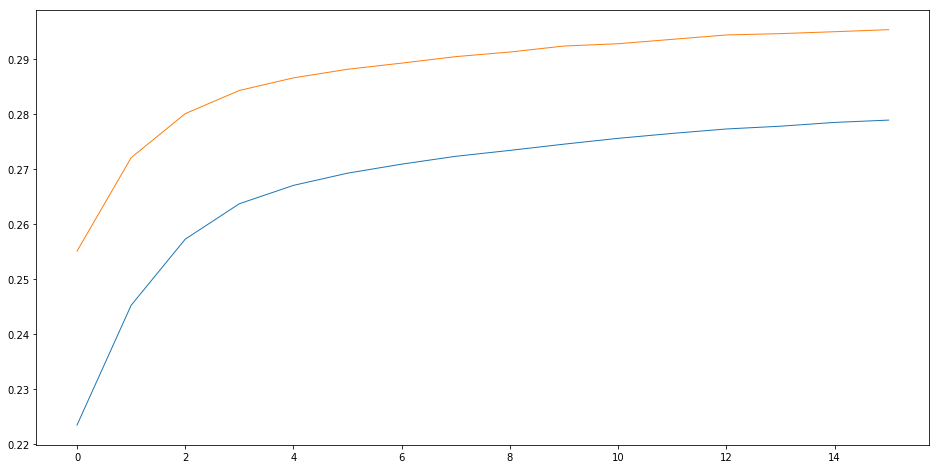

In [18]:
from matplotlib import pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)

def plot_accs(tra, vla):
    
    fig = plt.figure()
#     ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
#     ax.spines['right'].set_color('none')
#     ax.spines['top'].set_color('none')
#     plt.xticks([])
#     plt.yticks([])
    plt.plot(tra, label=f"Train Acc", linewidth=1)
    plt.plot(vla, label=f"Valid Acc", linewidth=1)
#     plt.plot(axa, label=f"DAdNN Acc", linewidth=1)
    plt.show()
    
    
def plot(trcs):
    layers = len(trcs[0])
    for l in range(layers):
        plt.plot(trcs[:,l], label=f"layer {l}")
    plt.show()
    
plot_accs(traces[0], traces[2])

## Plot LRs

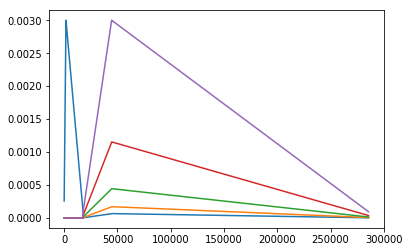

In [9]:
def plot(trcs):
    layers = len(trcs[0])
    for l in range(layers):
        plt.plot(trcs[:,l], label=f"layer {l}")
    plt.show()
    
plot(np.asarray(traces[-1][100:]))

In [ ]:
# Final save, just in case
# Dumping stuff
mt_save(save_dir,
        torch_stuff=[tosave('unsup_model_enc.torch', lm.encoder.state_dict()), tosave('unsup_model.torch', lm.state_dict())],
        pickle_stuff=[tosave('final_unsup_traces.pkl', traces), tosave('unsup_options.pkl', params)])

In [19]:
save_dir

PosixPath('resources/proc/imdb/models/3')